# Practice Session 03: Find near-duplicates using shingling


In this lab you’ll detect **near-duplicate texts** using:
- **shingling (n-grams)** + **Jaccard similarity**
- then a faster approach: **MinHash signatures**

**Before you run**
Put the dataset file (the `.json.gz`) in the same folder as this notebook, then run top-to-bottom.


# 0. Dataset


In [1]:
import io
import json
import gzip
import re
import random
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer

import datetime

In [4]:
# KEEP AS-IS

# Input file
INPUT_FILENAME = "CovidLockdownCatalonia.json.gz"

# Array for storing messages
messages = []

# IMPORTANT:
# 1. Set this to 1000 during development
# 2. Set this to 10000 once you have completed the development
#    There is no need to re-run the time estimation
#    What is important is to answer part 5 with 10000
# 3. Set this back to 1000 for delivering your code
MAX_MESSAGES = 1000

with gzip.open(INPUT_FILENAME, "rt", encoding="utf-8") as input_file:
    
    messages_read = 0
    for line in input_file:
            
        # Read message
        tweet = json.loads(line)

        # Keep only messages in Catalan
        if tweet["lang"] == "ca":
            
            messages_read += 1
            
            if messages_read <= MAX_MESSAGES:
                #author = tweet["user"]["screen_name"]
                message = tweet["full_text"]
                messages.append(message)

print("Read %d documents" % len(messages))

Read 1000 documents


In [5]:
# === PS03-01 TASK: Inspect the raw data ===
import random

# In ra 2 tin nhắn ngẫu nhiên để kiểm tra dữ liệu thô
sample_messages = random.sample(messages, 2)
for i, msg in enumerate(sample_messages):
    print(f"Message {i+1}:\n{msg}\n{'-'*20}")

Message 1:
RT @educaciocat: ℹ️ Quines mesures podem prendre amb els nens i nenes a casa 👧🧒, per evitar la propagació del #coronavirus 🦠? 

👉 Evitar qu…
--------------------
Message 2:
RT @gencat: 🚪 Tanquen a partir d'aquest moment totes les #biblioteques del Sistema Bibliotecari i de #Museus de Catalunya.
#coronavirus #CO…
--------------------


# 1. Auxiliary functions


In [6]:
# === PS03-02 TASK: Implement Jaccard similarity ===
def jaccard_similarity(l1, l2):
    set1 = set(l1)
    set2 = set(l2)
    
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    
    if union == 0:
        return 0.0
    return float(intersection) / union

In [7]:
# === PS03-03 TASK: Test Jaccard similarity ===
test_cases = [
    (["apple", "banana"], ["apple", "banana"]),     # Identical
    (["apple", "banana"], ["cherry", "dragon"]),   # Disjoint
    (["apple", "banana", "cherry"], ["banana", "cherry", "date"]) # Partial
]

for l1, l2 in test_cases:
    print(f"Set 1: {l1}")
    print(f"Set 2: {l2}")
    print(f"Similarity: {jaccard_similarity(l1, l2)}\n")

Set 1: ['apple', 'banana']
Set 2: ['apple', 'banana']
Similarity: 1.0

Set 1: ['apple', 'banana']
Set 2: ['cherry', 'dragon']
Similarity: 0.0

Set 1: ['apple', 'banana', 'cherry']
Set 2: ['banana', 'cherry', 'date']
Similarity: 0.5



In [8]:
# === PS03-04 TASK: Implement clean(text) ===
import unicodedata

def clean(text):
    # 1. Lowercase
    text = text.lower()
    # 2. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # 3. Remove accents/diacritics
    text = "".join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')
    # 4. Remove punctuation (keep letters/digits/spaces)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    # 5. Collapse multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [9]:
# === PS03-05 TASK: Test clean(text) ===
test_texts = [
    "Hello World!!! This is a test.",
    "Visit https://google.com for more info.",
    "Accents test: À È Ì Ò Ù và tiếng Việt"
]

for t in test_texts:
    print(f"Original: {t}")
    print(f"Cleaned : {clean(t)}\n")

Original: Hello World!!! This is a test.
Cleaned : hello world this is a test

Original: Visit https://google.com for more info.
Cleaned : visit for more info

Original: Accents test: À È Ì Ò Ù và tiếng Việt
Cleaned : accents test a e i o u va tieng viet



# 2. Implement an n-gram extractor


 # your code here


In [ ]:
# === PS03-06 TASK: Implement ngrams(text, size) ===
MIN_TOKEN_LENGTH = 2

def ngrams(text, size):
    tokens = text.split()
    # Drop tokens shorter than MIN_TOKEN_LENGTH
    tokens = [t for t in tokens if len(t) >= MIN_TOKEN_LENGTH]
    
    shingles = []
    for i in range(len(tokens) - size + 1):
        shingle = " ".join(tokens[i:i + size])
        shingles.append(shingle)
    return shingles




Tokens: ['aquesta', 'es', 'una', 'prova', 'per', 'als', 'ngrams', 'de', 'mida', 'tres']
3-grams: ['aquesta es una', 'es una prova', 'una prova per', 'prova per als', 'per als ngrams', 'als ngrams de', 'ngrams de mida', 'de mida tres']


In [11]:
# === PS03-07 TASK: Test ngrams ===
sample_clean = clean("Aquesta és una prova per als ngrams de mida tres")
print(f"Tokens: {sample_clean.split()}")
print(f"3-grams: {ngrams(sample_clean, 3)}")


Tokens: ['aquesta', 'es', 'una', 'prova', 'per', 'als', 'ngrams', 'de', 'mida', 'tres']
3-grams: ['aquesta es una', 'es una prova', 'una prova per', 'prova per als', 'per als ngrams', 'als ngrams de', 'ngrams de mida', 'de mida tres']


# 3. Estimation of brute force all-pairs method


In [12]:
# LEAVE AS-IS

def time_brute_force_similarities(messages, limit, ngram_size):
    if limit > len(messages):
        raise ValueError("Limit should be less than or equal than the number of messages")
        
    # Start a timer
    start = timer()

    # Iterate through document identifiers
    for docid1 in range(np.min([len(messages), limit])):

        # Clean document 1 and extract ngrams
        doc1 = clean(messages[docid1])
        ngrams1 = ngrams(doc1, ngram_size)

        # Iterate through document identifiers larger than doc2
        for docid2 in range(docid1+1, np.min([len(messages), limit])):
                         
            # Clean document 2 and extract ngrams
            doc2 = clean(messages[docid2])
            ngrams2 = ngrams(doc2, ngram_size)

            # Compute similarity
            similarity = jaccard_similarity(ngrams1, ngrams2)

    end = timer()
    return(end - start)

Limit 100 took 0.2706s
Limit 200 took 0.9774s
Limit 300 took 2.0925s
Limit 400 took 3.8985s
Limit 500 took 6.8369s


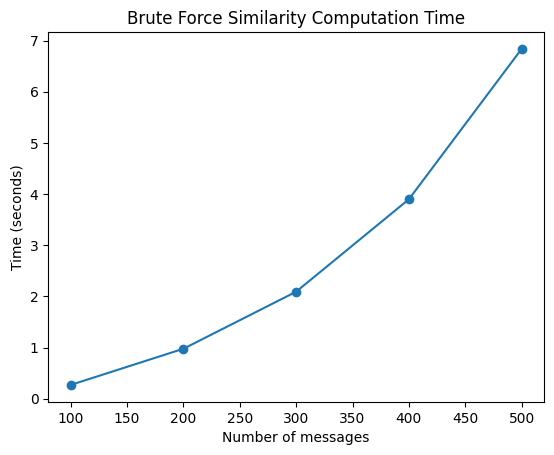

In [13]:
# === PS03-08 TASK: Plot brute-force timing ===
limits = [100, 200, 300, 400, 500]
timings = []
NGRAM_SIZE = 3

for lim in limits:
    t = time_brute_force_similarities(messages, lim, NGRAM_SIZE)
    timings.append(t)
    print(f"Limit {lim} took {t:.4f}s")

plt.plot(limits, timings, 'o-')
plt.title("Brute Force Similarity Computation Time")
plt.xlabel("Number of messages")
plt.ylabel("Time (seconds)")
plt.show()

### PS03-09 Written answer
Using your measured timings, estimate how long brute-force comparison would take for 10,000 messages.

- Show your calculation.
- State clearly what growth assumption you use (e.g., ~n^2 pairs).


# 4. Computing the doc-ngram matrix


## 4.1 Create list of all ngrams


 # YOUR CODE HERE


In [ ]:
# === PS03-10 TASK: Build ngram dictionaries ===
NGRAM_SIZE = 3
all_ngrams = set()

for msg in messages:
    cleaned = clean(msg)
    for ng in ngrams(cleaned, NGRAM_SIZE):
        all_ngrams.add(ng)

ngram_to_index = {ng: i for i, ng in enumerate(sorted(list(all_ngrams)))}
index_to_ngram = {i: ng for ng, i in ngram_to_index.items()}
num_distinct_ngrams = len(ngram_to_index)



Distinct ngrams: 11212
Sample: '012 consultes general' -> 0
Round-trip check: True


In [15]:
# === PS03-11 TASK: Test ngram dictionaries ===
print(f"Distinct ngrams: {num_distinct_ngrams}")
sample_ng = list(ngram_to_index.keys())[0]
idx = ngram_to_index[sample_ng]
print(f"Sample: '{sample_ng}' -> {idx}")
print(f"Round-trip check: {index_to_ngram[idx] == sample_ng}")

Distinct ngrams: 11212
Sample: '012 consultes general' -> 0
Round-trip check: True


## 2.2 Create table ngrams x documents


In [16]:
# LEAVE AS-IS

# Create dense matrix in which every cell contains the value "False"
M_ngram_doc = np.full((num_distinct_ngrams, len(messages)), False)

# Print the number of rows and columns of this matrix
# numpy.matrix.shape is a tuple, shape[0] is the number of rows, shape[1] the number of columns
print("Matrix dimensions: %d rows (distinct shingles) x %d columns (distinct documents)" % M_ngram_doc.shape)

Matrix dimensions: 11212 rows (distinct shingles) x 1000 columns (distinct documents)


 # replace this comment with your code


In [17]:
# === PS03-12 TASK: Fill M_ngram_doc ===
for j, msg in enumerate(messages):
    cleaned = clean(msg)
    for ng in ngrams(cleaned, NGRAM_SIZE):
        if ng in ngram_to_index:
            i = ngram_to_index[ng]
            M_ngram_doc[i, j] = True

In [18]:
# === PS03-13 TASK: Matrix density ===
num_true = np.sum(M_ngram_doc)
total_cells = M_ngram_doc.size
density = (num_true / total_cells) * 100
print(f"Matrix density: {density:.4f}%")


Matrix density: 0.1486%


In [19]:
# === PS03-14 TASK: Inspect specific rows ===
for idx in [9602, 941]:
    if idx < num_distinct_ngrams:
        print(f"Row {idx} (ngram): {index_to_ngram[idx]}")
        docids = np.where(M_ngram_doc[idx, :])[0]
        print(f"Found in docids: {docids[:10]}") # In tối đa 10 docs đầu
        print()

Row 9602 (ngram): salutcat govern les
Found in docids: [716]

Row 941 (ngram): avui hem fet
Found in docids: [278]



# 3. Implement a permutation generator


In [20]:
# === PS03-15 TASK: random_permutation(k) ===
def random_permutation(k):
    return random.sample(range(k), k)


In [24]:
# LEAVE AS-IS

# Permute a list according to a permutation
def permuter(original_list, permutation):
    permuted_list = []
    for index in permutation:
        permuted_list.append(original_list[index])
    return permuted_list

# Code for testing permutations
original_list_1 = ["1 (test1)", "2 (test2)", "3 (test3)", "4 (test4)", "5 (test5)"]
original_list_2 = ["1 (alpha)", "2 (gamma)", "3 (beta)", "4 (delta)", "5 (epsilon)"]

print("Test one permutation:")
permutation_1 = random_permutation(5)
print(permuter(original_list_1, permutation_1))
print(permuter(original_list_2, permutation_1))

print()

print("Test another permutation")
permutation_2 = random_permutation(5)
print(permuter(original_list_1, permutation_2))
print(permuter(original_list_2, permutation_2))

Test one permutation:
['3 (test3)', '1 (test1)', '4 (test4)', '2 (test2)', '5 (test5)']
['3 (beta)', '1 (alpha)', '4 (delta)', '2 (gamma)', '5 (epsilon)']

Test another permutation
['1 (test1)', '4 (test4)', '2 (test2)', '3 (test3)', '5 (test5)']
['1 (alpha)', '4 (delta)', '2 (gamma)', '3 (beta)', '5 (epsilon)']


# 4. Compute the signature of each document


In [22]:
# Leave this code as-is

NUM_PERMUTATIONS = 5

permutations = []

# Create the permutations
for i in range(NUM_PERMUTATIONS):
    permutation = random_permutation(num_distinct_ngrams)
    permutations.append(random_permutation(num_distinct_ngrams))
    
# Visualize the permutations by printing their first 4 elements
for i in range(len(permutations)):
    permutation = permutations[i]
    print("Permutation %d: %d, %d, %d, %d, ..." % (i,
                permutation[0], permutation[1], permutation[2], permutation[3] ))

Permutation 0: 3504, 10570, 9437, 5791, ...
Permutation 1: 5907, 2248, 5145, 2949, ...
Permutation 2: 8182, 3741, 5752, 4477, ...
Permutation 3: 3795, 9597, 2675, 6266, ...
Permutation 4: 8462, 125, 6938, 6823, ...


# Create permutations


In [23]:
# LEAVE AS-IS

# Find the first ngram in a document, according to a permutation
def find_first_one(docid, permutation):
    for shingle_id in permutation:
        if M_ngram_doc[shingle_id, docid] == True:
            return shingle_id
    return -1

In [26]:
# === PS03-16 TASK: Create M_signature_doc ===
M_signature_doc = np.full((NUM_PERMUTATIONS, len(messages)), -1)

for p_idx in range(NUM_PERMUTATIONS):
    perm = permutations[p_idx]
    for d_idx in range(len(messages)):
        M_signature_doc[p_idx, d_idx] = find_first_one(d_idx, perm)

In [27]:
# Leave this code as-is

def extract_ngrams(docid):
    return [x for x in range(num_distinct_ngrams) if M_ngram_doc[x, docid] == True]

def extract_signature(docid):
    return [M_signature_doc[x, docid] for x in range(NUM_PERMUTATIONS)]

def print_sig(messages, M_ngram_doc, M_signature_doc, i):
    print("Document #%d" % i)
    print("Message       : %s" % messages[i])
    print("Clean message : %s" % clean(messages[i]))
    print("Ngrams        : %s" % extract_ngrams(i))
    #for ngram_index in extract_ngrams(i):
    #   print("     ", index_to_ngram[ngram_index])
    print("Signature     : %s" % extract_signature(i))

# Print two messages and their signatures

print_sig(messages, M_ngram_doc, M_signature_doc, 850 )
print()
print_sig(messages, M_ngram_doc, M_signature_doc, 400 )

Document #850
Message       : RT @btvnoticies: DIRECTE | Quim Torra anuncia el confinament de tot Catalunya

Pots seguir-ho en #directebetevé aquí ⤵

https://t.co/vW0uEY…
Clean message : rt btvnoticies directe quim torra anuncia el confinament de tot catalunya pots seguirho en directebeteve aqui
Ngrams        : [693, 1089, 1311, 1649, 2835, 3390, 3635, 4121, 8136, 8764, 9143, 9749, 10487, 10511]
Signature     : [np.int64(8764), np.int64(8136), np.int64(2835), np.int64(9143), np.int64(1311)]

Document #400
Message       : RT @gencat: 🔴 El @govern de la @gencat anuncia el #confinament de tot Catalunya.

Davant l’emergència de la #COVID19, el missatge és clau:…
Clean message : rt gencat el govern de la gencat anuncia el confinament de tot catalunya davant lemergencia de la covid19 el missatge es clau
Ngrams        : [693, 1292, 1649, 2086, 2313, 2510, 2518, 2835, 3635, 3735, 3761, 5019, 5020, 5110, 5794, 5847, 6179, 6938, 9280, 10509]
Signature     : [np.int64(2086), np.int64(5019), np.in

# 5. Compare all pairs of signatures


# Iterate through all documents


In [28]:
# === PS03-17 TASK: Compare signatures ===
threshold = int(len(messages) * 0.005) # 0.5%
matches = []

for i in range(len(messages)):
    count = 0
    sig_i = M_signature_doc[:, i]
    for j in range(len(messages)):
        if i == j: continue
        sig_j = M_signature_doc[:, j]
        # Full match if all signatures are equal
        if np.array_equal(sig_i, sig_j):
            count += 1
    
    if count >= threshold:
        print(f"Doc {i} has {count} matches. Content: {messages[i][:100]}...")

Doc 2 has 5 matches. Content: RT @XSalaimartin: Fa temps que sabem que aquest tal Garcia-Page és un miserable. Però amb això se su...
Doc 16 has 6 matches. Content: RT @emergenciescat: ⚠️ Es demana a la ciutadania limitar al màxim i, si es pot, EVITAR DESPLAÇAMENTS...
Doc 22 has 7 matches. Content: RT @ramoncotarelo: Encara que no ho sembli, hi ha coses pitjors que el coronavirus: els polítics inc...
Doc 32 has 5 matches. Content: RT @Laksmiz: #MarcaEspaña: Ple absolut a la discoteca de Pachá de Madrid que no tanca pel coronaviru...
Doc 53 has 5 matches. Content: RT @Oriol_Pintos: Sóc advocat laboralista. Davant aquesta situació d'incertesa jurídica generalitzad...
Doc 84 has 6 matches. Content: RT @emergenciescat: ⚠️ Es demana a la ciutadania limitar al màxim i, si es pot, EVITAR DESPLAÇAMENTS...
Doc 85 has 5 matches. Content: RT @vpartal: Els Mossos diuen que és més senzill confinar el Principat que diverses ciutats a la veg...
Doc 95 has 9 matches. Content: RT @govern: ▶️ #President

### PS03-18 Written answer
Pick one pair that looks like a duplicate/near-duplicate from your output.
Explain (briefly) why the text changed so little (what kind of copying/forwarding behavior does it suggest?).


### PS03-19 Written answer
Pick:
- one "original" tweet, and
- one near-duplicate that is NOT identical to it.
Explain what changed (e.g., a hashtag, punctuation, a small phrase) and why it still gets flagged as near-duplicate.


# DELIVER (individually)
